In [1]:
import sys
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray
from keras import applications
from keras.models import Model
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import regularizers
from datetime import datetime

In [2]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [3]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i > 3:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6


In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 10
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 45

In [7]:
from utils import *

In [8]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list

        input_file = open(DATA_PATH, 'r')
        aug_probability = oversample(input_file)
        input_file.close()

        oversample_file = open("./oversample_training_data.txt",'r')
        aug(oversample_file , aug_probability)
        
        oversample_file.close()
        oversample_file = open("./oversample_training_data.txt",'r')
        for line in oversample_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        oversample_file.close()

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
#         image = preprocess_input(image)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [9]:
dataset = DatasetGenerator().generate()

In [10]:
from keras.regularizers import l2

In [11]:
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import ResNet152V2
class conv_leaky_relu(Model):
	def __init__(self, filters, size, stride):
		super(conv_leaky_relu, self).__init__()

		self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn = keras.layers.BatchNormalization()
		self.LeakyReLU = layers.LeakyReLU(0.1)

	def call(self, inputs, training=False):
		x = self.bn(self.conv(inputs), training=training)
		x = self.LeakyReLU(x)
		return x


class yolo(Model):
	def __init__(self, training):
		super(yolo, self).__init__()

		self.training = training

		self.backbone = ResNet152V2(include_top=False, weights='imagenet')
		# self.backbone = ResNet50V2(include_top=False, weights='imagenet')
		# self.backbone = Xception(include_top=False, weights='imagenet')
		# self.backbone = NASNetLarge(include_top=False, weights='imagenet')
		#self.backbone = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')

		for layer in self.backbone.layers:
			layer.trainable = False
			# layer.trainable = True
		self.conv1 = conv_leaky_relu(1024, 3, 1)
		self.conv2 = conv_leaky_relu(1024, 3, 2)
		self.conv3 = conv_leaky_relu(1024, 3, 1)
		self.conv4 = conv_leaky_relu(1024, 3, 1)
		self.flatten = layers.Flatten()
		self.dense1 = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn1 = keras.layers.BatchNormalization()
		self.leakyRelu1 = layers.LeakyReLU(0.1)
		self.dropout1 = layers.Dropout(0.1)
		self.dense3 = layers.Dense(2048, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn3 = keras.layers.BatchNormalization()
		self.leakyRelu3 = layers.LeakyReLU(0.1)
		self.dropout3 = layers.Dropout(0.1)
		self.dense2 = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4))
		self.dropout2 = layers.Dropout(0.1)

	def call(self, inputs):
		x = self.backbone(inputs)
		x = self.conv1(x, training=self.training)
		x = self.conv2(x, training=self.training)
		x = self.conv3(x, training=self.training)
		x = self.conv4(x, training=self.training)
		x = self.flatten(x)
		x = self.bn1(self.dense1(x), training=self.training)
		x = self.leakyRelu1(x)
		x = self.dropout1(x)
		x = self.bn3(self.dense3(x), training=self.training)
		x = self.leakyRelu3(x)
		x = self.dropout2(x)
		x = self.dense2(x)
		x = self.dropout2(x)
		return x

In [12]:
YOLO = yolo(training=True)
YOLO.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))

In [13]:
#YOLO.summary()

In [14]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [15]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [16]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [17]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=10, checkpoint_name='yolo')

In [18]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [19]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2021-11-25 14:14:42.169454, start training.
2021-11-25 14:25:08.740353, Epoch 1: loss 12.07
Saved checkpoint for epoch 1: ./ckpts/YOLO\yolo-1
2021-11-25 14:35:30.301098, Epoch 2: loss 7.90
Saved checkpoint for epoch 2: ./ckpts/YOLO\yolo-2
2021-11-25 14:45:51.754332, Epoch 3: loss 6.84
Saved checkpoint for epoch 3: ./ckpts/YOLO\yolo-3
2021-11-25 14:56:13.963121, Epoch 4: loss 6.44
Saved checkpoint for epoch 4: ./ckpts/YOLO\yolo-4
2021-11-25 15:06:35.706233, Epoch 5: loss 5.92
Saved checkpoint for epoch 5: ./ckpts/YOLO\yolo-5
2021-11-25 15:16:58.600458, Epoch 6: loss 5.30
Saved checkpoint for epoch 6: ./ckpts/YOLO\yolo-6
2021-11-25 15:27:23.465699, Epoch 7: loss 5.06
Saved checkpoint for epoch 7: ./ckpts/YOLO\yolo-7
2021-11-25 15:37:45.883542, Epoch 8: loss 4.68
Saved checkpoint for epoch 8: ./ckpts/YOLO\yolo-8
2021-11-25 15:48:06.660787, Epoch 9: loss 4.40
Saved checkpoint for epoch 9: ./ckpts/YOLO\yolo-9
2021-11-25 15:58:27.671343, Epoch 10: loss 4.20
Saved checkpoint for epoch 10: ./c

In [20]:
from ensemble_boxes import *
def process_outputs11111(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the bboxes that have confidence non less than 0.5  (sample at most 5 boxes)
    threshold = 0.025
    sample = 20
    _P = P.flatten()
    indexes = np.asarray([x for x in np.argsort(_P)[-sample:] if _P[x] >= threshold])
#     print(indexes)
    # if no box is included(indexes == []), get the most confident one (temporary solution)
    if len(indexes) == 0:
        indexes = np.asarray([np.argmax(_P)])
    idx_cnts = len(indexes)
    indexes = np.unravel_index(indexes, P.shape)
    max_conf = P[indexes]
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    class_num = []
    
    indexes = np.asarray(indexes)
    for cnts in range(idx_cnts):
        index = indexes[:,cnts]
    
#     max_conf = np.max(P)
#     index = np.argmax(P)

#     index = np.unravel_index(index, P.shape)

        _class_num = index[3]

        coordinate = np.reshape(coordinate, 
                                (CELL_SIZE, 
                                 CELL_SIZE,
                                 BOXES_PER_CELL, 
                                 4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        _xmin = xcenter - w/2.0
        _ymin = ycenter - h/2.0

        _xmax = _xmin + w
        _ymax = _ymin + h
        
        if(_xmin <= 0):
            _xmin = 0.01
        if(_ymin <= 0):
            _ymin = 0.01
        if(_xmax >= IMAGE_SIZE):
            _xmax = IMAGE_SIZE-0.01
        if(_ymax >= IMAGE_SIZE):
            _ymax = IMAGE_SIZE-0.01
            
        xmin.append(_xmin)
        ymin.append(_ymin)
        xmax.append(_xmax)
        ymax.append(_ymax)
        class_num.append(_class_num)
    
    boxes_list = []
    scores_list = max_conf
    labels_list = class_num


    weights =[3]
    iou_thr = 0.5
    skip_box_thr = 0.0001
    sigma = 0.1

    xmin      = np.asarray(xmin)
    ymin      = np.asarray(ymin) 
    xmax      = np.asarray(xmax)
    ymax      = np.asarray(ymax)
    class_num = np.asarray(class_num)
    max_conf  = np.asarray(max_conf)

    for i in range(len(xmin)):
        box_temp = [ xmin[i]/448., ymin[i]/448., xmax[i]/448., ymax[i]/448.]
        boxes_list.append(box_temp)

    boxes, scores, labels = nms([boxes_list], [scores_list], [labels_list], weights=None, iou_thr=iou_thr)

    xmin_NMS = []
    ymin_NMS = []
    xmax_NMS = []
    ymax_NMS = []
    for i in range(len(labels)):
#             class_name = classes_name[labels[i]]
        xmin_NMS.append(int(boxes[i][0]*448))
        ymin_NMS.append(int(boxes[i][1]*448))
        xmax_NMS.append(int(boxes[i][2]*448))
        ymax_NMS.append(int(boxes[i][3]*448))   

    xmin_NMS_big = []
    ymin_NMS_big = []
    xmax_NMS_big = []
    ymax_NMS_big = []
    label_NMS_big= []
    scores_NMS_big=[]
    
    for i in range(len(labels)):
        if((xmax_NMS[i]-xmin_NMS[i] >= 10) and (ymax_NMS[i]-ymin_NMS[i] >= 10)):
                xmin_NMS_big.append(xmin_NMS[i])
                ymin_NMS_big.append(ymin_NMS[i])
                xmax_NMS_big.append(xmax_NMS[i])
                ymax_NMS_big.append(ymax_NMS[i])
                label_NMS_big.append(labels[i])
                scores_NMS_big.append(scores[i])
    return np.asarray(xmin_NMS_big), np.asarray(ymin_NMS_big), np.asarray(xmax_NMS_big), np.asarray(ymax_NMS_big), np.asarray(label_NMS_big), np.asarray(scores_NMS_big)
#     return np.asarray(xmin_NMS), np.asarray(ymin_NMS), np.asarray(xmax_NMS), np.asarray(ymax_NMS), np.asarray(labels), np.asarray(scores)

In [21]:
# def process_outputs(outputs):
#     """
#     Process YOLO outputs into bou
#     """

#     class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
#     conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
#     class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
#     confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
#     boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
#     predicts = np.concatenate([class_probs, confs, boxes], 3)

#     p_classes = predicts[0, :, :, 0:20]
#     C = predicts[0, :, :, 20:22]
#     coordinate = predicts[0, :, :, 22:]

#     p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
#     C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

#     P = C * p_classes
#     #P's shape [7, 7, 2, 20]

#     #choose the most confidence one
#     max_conf = np.max(P)
#     index = np.argmax(P)

#     index = np.unravel_index(index, P.shape)

#     class_num = index[3]

#     coordinate = np.reshape(coordinate, 
#                             (CELL_SIZE, 
#                              CELL_SIZE,
#                              BOXES_PER_CELL, 
#                              4))

#     max_coordinate = coordinate[index[0], index[1], index[2], :]

#     xcenter = max_coordinate[0]
#     ycenter = max_coordinate[1]
#     w = max_coordinate[2]
#     h = max_coordinate[3]

#     xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
#     ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

#     w = w * IMAGE_SIZE
#     h = h * IMAGE_SIZE

#     xmin = xcenter - w/2.0
#     ymin = ycenter - h/2.0

#     xmax = xmin + w
#     ymax = ymin + h

#     return xmin, ymin, xmax, ymax, class_num, max_conf

In [22]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [23]:
from keras.regularizers import l2
YOLO = yolo(training=False)
YOLO.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))

ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-45')


In [24]:
@tf.function
def prediction_step(img):
    return YOLO(img)

In [25]:
output_file = open('./test_prediction_res152.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs11111(prediction_step(test_img[i:i+1]))
        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for j in range(len(xmin)):
            xmin[j], ymin[j], xmax[j], ymax[j] = np.int(xmin[j]*(img_w[i:i+1]/IMAGE_SIZE)), np.int(ymin[j]*(img_h[i:i+1]/IMAGE_SIZE)), np.int(xmax[j]*(img_w[i:i+1]/IMAGE_SIZE)), np.int(ymax[j]*(img_h[i:i+1]/IMAGE_SIZE))
            class_num[j] = np.int(class_num[j])
            output_file.write(" %d %d %d %d %d %f" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))  
        output_file.write("\n")
                
output_file.close()
import sys
sys.path.insert(0, './evaluate')
import evaluate
evaluate.evaluate('./test_prediction_res152.txt', './output_file_res152.csv')

C:\Users\NTHU\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
C:\Users\NTHU\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 6 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordina

Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 8 boxes coordinates < 0
Warning. Fixed 7 boxes coordinates > 1. 

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 9 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 4 boxes coordinates < 0
Warning. Fixed 7 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at

Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 6 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 7 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 4 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. 

Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 10 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 4 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1.

Warning. Fixed 13 boxes coordinates < 0
Warning. Fixed 13 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 7 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 6 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 5 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 5 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 6 boxes coordinates < 0
Warning. Fixed 4 boxes coordi

chair
0.07595119
xmin=209,ymin=238,xmax=365,ymax=350
chair
0.06103895
xmin=112,ymin=209,xmax=217,ymax=352
chair
0.056671366
xmin=207,ymin=273,xmax=376,ymax=399
chair
0.043179125
xmin=136,ymin=267,xmax=317,ymax=410
chair
0.033407554
xmin=58,ymin=221,xmax=158,ymax=348
chair
0.028946495
xmin=161,ymin=205,xmax=290,ymax=370
chair
0.028583718
xmin=282,ymin=279,xmax=413,ymax=419
diningtable
0.10320984
xmin=209,ymin=238,xmax=365,ymax=350
diningtable
0.066299416
xmin=207,ymin=273,xmax=376,ymax=399
diningtable
0.059311483
xmin=112,ymin=209,xmax=217,ymax=352
diningtable
0.039813843
xmin=136,ymin=267,xmax=317,ymax=410
diningtable
0.035562992
xmin=161,ymin=205,xmax=290,ymax=370
diningtable
0.026612367
xmin=58,ymin=221,xmax=158,ymax=348
sofa
0.039952956
xmin=112,ymin=209,xmax=217,ymax=352
sofa
0.038516413
xmin=209,ymin=238,xmax=365,ymax=350


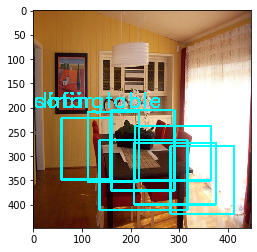

In [26]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000006.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs11111(y_pred)
# print(class_num)
for i in range(len(xmin)):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
    print(class_name)
    print(conf[i])
    print("xmin={},ymin={},xmax={},ymax={}".format(int(xmin[i]), int(ymin[i]), int(xmax[i]), int(ymax[i])))

plt.imshow(resized_img)
plt.show()

In [27]:
"""import sys
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_res50.csv')"""

'import sys\nsys.path.insert(0, \'./evaluate\')\nimport evaluate\n#evaluate.evaluate("input prediction file name", "desire output csv file name")\nevaluate.evaluate(\'./test_prediction.txt\', \'./output_file_res50.csv\')'